In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from collections import OrderedDict

font = {'family' : 'DejaVu Sans',
        'weight': 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

bar_codes = ['#7293cb', '#e1974c', '#84ba5b', '#d35e60', '#808585', '#9067a7',
             '#ab6857', '#ccc210']
line_codes = ['#396ab1', '#da7c30', '#3f9651', '#cc2529', '#535154', '#6b4c9a',
              '#922428', '#948b3d']
comp_codes = {'bzip2': 0,
              'deflate': 1,
              'lz4': 2,
              'lzf': 3,
              'lzma': 4,
              'lzo-1a': 5,
              'lzo1x-1': 6,
              'snappy': 7
             }

In [ ]:
cpu_lzf = pd.read_csv('../benchmarks/lzf.out', sep='|', header=None)
cpu_lzf.columns = ['alg', 'comp_size', 'compress_us', 'decompress_us', 'file', 'block']

In [ ]:
lzf_file = cpu_lzf.groupby('file').agg(['mean', 'std', 'min', 'max'])

In [ ]:
# drop first val, because of setup latency
cpu_lzf = cpu_lzf[1:]

In [ ]:
file_groups = cpu_lzf.groupby('file')

In [ ]:
# find stds for each group
stds = file_groups.aggregate(np.std)
stds = stds.replace(np.NaN, 0)

In [ ]:
# find mean values
means = file_groups.aggregate(np.mean)

In [ ]:
# find sample bounds
upper = means + (stds * 3)
lower = means - (stds * 3)

In [ ]:
orig_len = len(ecoli)
ecoli = file_groups.get_group('canterbury-large/E.coli')
compress_idx = [np.abs(ecoli.compress_us-ecoli.compress_us.mean())<= 3*ecoli.compress_us.std()]
decompress_idx = [np.abs( ecoli.decompress_us-ecoli.decompress_us.mean() )<= 3*ecoli.decompress_us.std()]
compress_decomp_idx = compress_idx and decompress_idx
in_std_len = len(ecoli[compress_decomp_idx[0]])
print('Removed {} of {} records, outside of 3 std dvs'.format(orig_len - in_std_len, orig_len))
f, axarr = plt.subplots(1, 2, figsize=(12, 8))
axarr[0].bar(1, ecoli[compress_decomp_idx[0]]['compress_us'].mean())
axarr[1].bar(1, ecoli[compress_decomp_idx[0]]['decompress_us'].mean())

In [ ]:
ecoli.alg.iloc[0]

In [ ]:
len([c for c in compress_decomp_idx[0] if c])

In [ ]:
files = list(file_groups.groups.keys())


In [ ]:
CompressOut = namedtuple('CompressOut', 'path type')

In [ ]:
compress_outs = [
    CompressOut('../benchmarks/bzip.out', 'bzip'),
    CompressOut('../benchmarks/gzip.out', 'gzip'),
    CompressOut('../benchmarks/lz4.out', 'lz4'),
    CompressOut('../benchmarks/lzf.out', 'lzf'),
    CompressOut('../benchmarks/lzma.out', 'lzma'),
    CompressOut('../benchmarks/lzo.out', 'lzo'),
    CompressOut('../benchmarks/snappy.out', 'snappy')
]
frontend = [
    CompressOut('../benchmarks/lz4.out', 'lz4'),
    CompressOut('../benchmarks/lzf.out', 'lzf'),
    CompressOut('../benchmarks/lzo.out', 'lzo'),
]
backend = [
    CompressOut('../benchmarks/bzip.out', 'bzip'),
    CompressOut('../benchmarks/gzip.out', 'gzip'),
    CompressOut('../benchmarks/lzma.out', 'lzma'),
]

In [ ]:
compressed_dfs = [
    pd.read_csv(c.path, sep='|', header=None) for c in frontend
]

In [ ]:
fig, axarr = plt.subplots(25, 3, figsize=(24, 64))
metrics = ['comp_size', 'compress_us', 'decompress_us']
i = 1
algs = []
file_names = None
for c_df in compressed_dfs:
    c_df.columns = ['alg', 'comp_size', 'compress_us', 'decompress_us', 'file', 'block']
    c_df = c_df.groupby(('alg','file'))
    
    if not file_names:
        file_names = [f[1].replace('//', '/') for f in list(c_df.groups.keys())]

    files = list(c_df.groups.keys())
    
    #assert [f.replace('//', '/') for f[1] in files] == file_names
    
    algs_in_df = dict()
    for f in range(len(files)):
        alg = files[f][0]
        if alg not in algs_in_df:
            algs.append(alg)
            algs_in_df[alg] =  i
            i += 1
            
        file_df = c_df.get_group(files[f])
        file_df_len = len(file_df)
        if file_df_len > 1:
            compress_idx = [
                np.abs(file_df.compress_us-file_df.compress_us.mean())<= 3*file_df.compress_us.std()]
            decompress_idx = [
                np.abs(file_df.decompress_us-file_df.decompress_us.mean())<= 3*file_df.decompress_us.std()]
            comp_and_decomp = compress_idx and decompress_idx
        else:
            # quick and dirty way to handle the 1 block example
            comp_and_decomp = [[True]]
        comp_and_decomp_len = len([c for c in comp_and_decomp[0] if c])
        print('{}, {}, Removed {} of {} records'.format(file_df.alg.iloc[0], file_df.file.iloc[0],
                                                        file_df_len - comp_and_decomp_len, file_df_len))
        for m in range(len(metrics)):
            axarr[f % 25, m].bar(algs_in_df[alg], file_df[comp_and_decomp[0]][metrics[m]].mean())
                   
for f in range(len(file_names)):
    axarr[f, 0].set_ylabel(file_names[f])
    for m in range(len(metrics)):
        axarr[f, m].set_title(metrics[m])
        axarr[f, m].set_xticks(range(len(algs) + 1))
        axarr[f, m].set_xticklabels([''] + algs, minor=False)
plt.subplots_adjust(top=0.92, bottom=0.08, hspace=0.4)
#plt.show()
plt.savefig('compression_algorithms_frontend_by_file.png')

In [318]:
alg_groups = {
    "frontend" : [
        CompressOut('../benchmarks/lz4.out', 'lz4'),
        CompressOut('../benchmarks/lzf.out', 'lzf'),
        CompressOut('../benchmarks/lzo.out', 'lzo')
    ],
    "backend": [
        CompressOut('../benchmarks/bzip.out', 'bzip'),
        CompressOut('../benchmarks/gzip.out', 'gzip'),
        CompressOut('../benchmarks/lzma.out', 'lzma')
    ]
}

lz4, canterbury/alice29.txt, Removed 13 of 55143 records
lzf, canterbury/alice29.txt, Removed 81 of 55143 records
lzo-1a, canterbury/alice29.txt, Removed 478 of 55143 records
lzo1x-1, canterbury/alice29.txt, Removed 53 of 55143 records


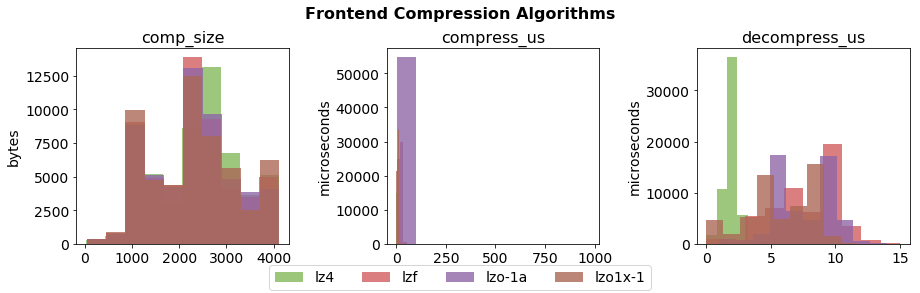

In [314]:
alg_group = 'frontend'
chart = 'hist'

compressed_dfs = [
    pd.read_csv(c.path, sep='|', header=None) for c in alg_groups[alg_group]
]

fig, axarr = plt.subplots(1, 3, figsize=(13, 4))
metrics = ['comp_size', 'compress_us', 'decompress_us']
i = 1
algs = []
file_names = None
for c_df in compressed_dfs:
    c_df.columns = ['alg', 'comp_size', 'compress_us', 'decompress_us', 'file', 'block']
    c_df = c_df.groupby('alg')
    
    algs_in_df = dict()
    
    for alg in list(c_df.groups.keys()):
        if alg not in algs_in_df:
            algs.append(alg)
            algs_in_df[alg] =  i
            i += 1
            
        alg_df = c_df.get_group(alg)
        alg_df_len = len(alg_df)
        if alg_df_len > 1:
            compress_idx = [
                np.abs(alg_df.compress_us-alg_df.compress_us.mean())<= 3*alg_df.compress_us.std()]
            decompress_idx = [
                np.abs(alg_df.decompress_us-alg_df.decompress_us.mean())<= 3*alg_df.decompress_us.std()]
            comp_and_decomp = compress_idx and decompress_idx
        else:
            # quick and dirty way to handle the 1 block example
            comp_and_decomp = [[True]]
        comp_and_decomp_len = len([c for c in comp_and_decomp[0] if c])
        print('{}, {}, Removed {} of {} records'.format(alg_df.alg.iloc[0], alg_df.file.iloc[0],
                                                        alg_df_len - comp_and_decomp_len, alg_df_len))
        for m in range(len(metrics)):
            if chart == 'bar':
                axarr[m].bar(algs_in_df[alg], alg_df[comp_and_decomp[0]][metrics[m]].mean(),
                             color=bar_codes[comp_codes[alg]])
            elif chart == 'hist':
                axarr[m].hist(alg_df[comp_and_decomp[0]][metrics[m]],
                             color=bar_codes[comp_codes[alg]], alpha=0.8)
                
for m in range(len(metrics)):
    axarr[m].set_title(metrics[m], fontsize=16)
    if chart == 'bar':
        axarr[m].set_xticks(range(len(algs) + 1))
        axarr[m].set_xticklabels([''] + algs, minor=False)
    if m == 0:
        axarr[m].set_ylabel('bytes')
    else:
        axarr[m].set_ylabel('microseconds')
plt.subplots_adjust(top=0.92, bottom=0.08, hspace=0.5, wspace=0.4)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("{} Compression Algorithms".format(alg_group.capitalize()), weight='bold', size=16)

if chart == 'hist':
    fig.legend(algs, loc='lower center', ncol=len(algs),  borderaxespad=0.2)

plt.show()
#plt.savefig('compression_algorithms_{}.png'.format(alg_group))

# Frontend Hist by alg

lz4, canterbury/alice29.txt, Removed 13 of 55143 records
lzf, canterbury/alice29.txt, Removed 81 of 55143 records
lzo-1a, canterbury/alice29.txt, Removed 478 of 55143 records
lzo1x-1, canterbury/alice29.txt, Removed 53 of 55143 records


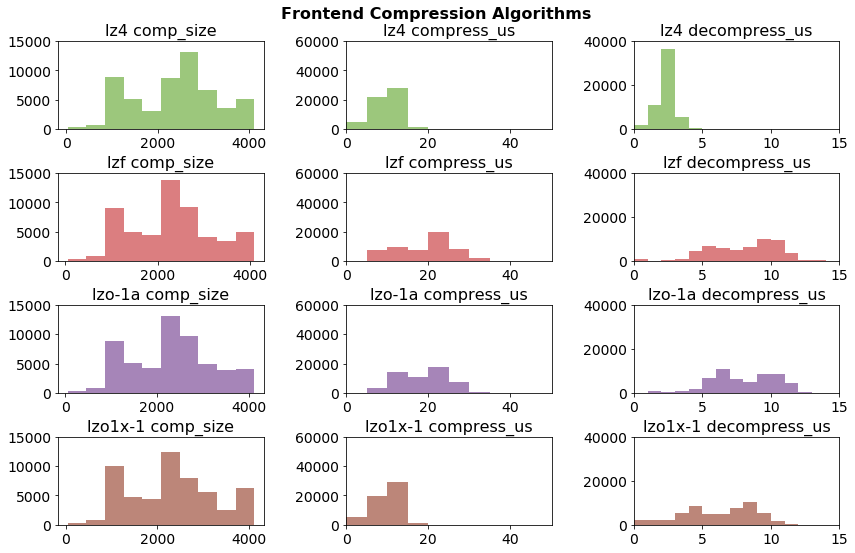

In [387]:
alg_group = 'frontend'
chart = 'hist'

compressed_dfs = [
    pd.read_csv(c.path, sep='|', header=None) for c in alg_groups[alg_group]
]

fig, axarr = plt.subplots(len(compressed_dfs) + 1, 3, figsize=(14, 8))
metrics = ['comp_size', 'compress_us', 'decompress_us']
i = 0
algs = []
file_names = None
comp_x = range(50)
decomp_x = range(15)
bin_ranges = [None, range(0, 50, 5), range(0, 15, 1)]

decomp_limit = 0
for c_df in compressed_dfs:
    c_df.columns = ['alg', 'comp_size', 'compress_us', 'decompress_us', 'file', 'block']
    c_df = c_df.groupby('alg')
    
    algs_in_df = dict()
    
    for alg in list(c_df.groups.keys()):
        if alg not in algs_in_df:
            algs.append(alg)
            algs_in_df[alg] =  i
            i += 1
            
        alg_df = c_df.get_group(alg)
        alg_df_len = len(alg_df)
        if alg_df_len > 1:
            compress_idx = [
                np.abs(alg_df.compress_us-alg_df.compress_us.mean())<= 3*alg_df.compress_us.std()]
            decompress_idx = [
                np.abs(alg_df.decompress_us-alg_df.decompress_us.mean())<= 3*alg_df.decompress_us.std()]
            comp_and_decomp = compress_idx and decompress_idx
        else:
            # quick and dirty way to handle the 1 block example
            comp_and_decomp = [[True]]
        comp_and_decomp_len = len([c for c in comp_and_decomp[0] if c])
        print('{}, {}, Removed {} of {} records'.format(alg_df.alg.iloc[0], alg_df.file.iloc[0],
                                                        alg_df_len - comp_and_decomp_len, alg_df_len))
        for m in range(len(metrics)):
            if chart == 'bar':
                axarr[i, m].bar(algs_in_df[alg], alg_df[comp_and_decomp[0]][metrics[m]].mean(),
                             color=bar_codes[comp_codes[alg]])
            elif chart == 'hist':
                axarr[algs_in_df[alg], m].hist(alg_df[comp_and_decomp[0]][metrics[m]],
                      color=bar_codes[comp_codes[alg]], alpha=0.8, bins=bin_ranges[m])
for alg in range(len(algs)):
    axarr[alg, 0].set_ylim(0, 15000)
    axarr[alg, 1].set_xlim(0, 50)
    axarr[alg, 1].set_ylim(0, 60000)
    axarr[alg, 2].set_xlim(0, 15)
    axarr[alg, 2].set_ylim(0, 40000)
    for m in range(len(metrics)):
        axarr[alg, m].set_title('{} {}'.format(algs[alg], metrics[m]), fontsize=16)
        #if m == 0:
        #    axarr[alg, m].set_ylabel('bytes')
        #else:
        #    axarr[alg, m].set_ylabel('microseconds')
plt.subplots_adjust(top=0.92, bottom=0.08, hspace=0.5, wspace=0.4)
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("{} Compression Algorithms".format(alg_group.capitalize()), weight='bold', size=16)

#if chart == 'hist':
#    fig.legend(algs, loc='lower center', ncol=len(algs),  borderaxespad=0.2)

plt.show()
#plt.savefig('compression_algorithms_hist_by_alg_{}.png'.format(alg_group))

# Backend Hist by alg

bzip2, canterbury/alice29.txt, Removed 58 of 55143 records
deflate, canterbury/alice29.txt, Removed 632 of 55143 records
lzma, canterbury/alice29.txt, Removed 89 of 55143 records


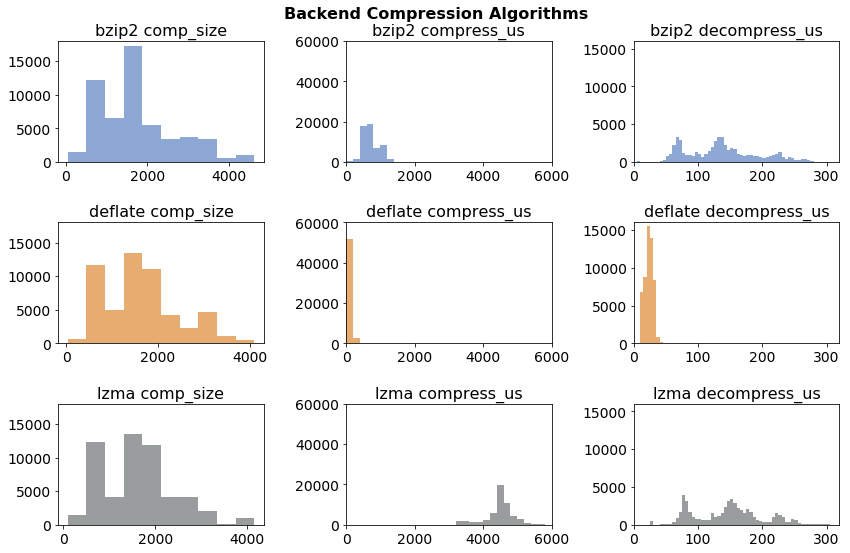

In [393]:
alg_group = 'backend'
chart = 'hist'

compressed_dfs = [
    pd.read_csv(c.path, sep='|', header=None) for c in alg_groups[alg_group]
]

fig, axarr = plt.subplots(len(compressed_dfs), 3, figsize=(14, 8))
metrics = ['comp_size', 'compress_us', 'decompress_us']
i = 0
algs = []
file_names = None
comp_x = range(50)
decomp_x = range(15)
bin_ranges = [None, range(0, 6000, 200), range(0, 320, 5)]

decomp_limit = 0
for c_df in compressed_dfs:
    c_df.columns = ['alg', 'comp_size', 'compress_us', 'decompress_us', 'file', 'block']
    c_df = c_df.groupby('alg')
    
    algs_in_df = dict()
    
    for alg in list(c_df.groups.keys()):
        if alg not in algs_in_df:
            algs.append(alg)
            algs_in_df[alg] =  i
            i += 1
            
        alg_df = c_df.get_group(alg)
        alg_df_len = len(alg_df)
        if alg_df_len > 1:
            compress_idx = [
                np.abs(alg_df.compress_us-alg_df.compress_us.mean())<= 3*alg_df.compress_us.std()]
            decompress_idx = [
                np.abs(alg_df.decompress_us-alg_df.decompress_us.mean())<= 3*alg_df.decompress_us.std()]
            comp_and_decomp = compress_idx and decompress_idx
        else:
            # quick and dirty way to handle the 1 block example
            comp_and_decomp = [[True]]
        comp_and_decomp_len = len([c for c in comp_and_decomp[0] if c])
        print('{}, {}, Removed {} of {} records'.format(alg_df.alg.iloc[0], alg_df.file.iloc[0],
                                                        alg_df_len - comp_and_decomp_len, alg_df_len))
        for m in range(len(metrics)):
            if chart == 'bar':
                axarr[i, m].bar(algs_in_df[alg], alg_df[comp_and_decomp[0]][metrics[m]].mean(),
                             color=bar_codes[comp_codes[alg]])
            elif chart == 'hist':
                axarr[algs_in_df[alg], m].hist(alg_df[comp_and_decomp[0]][metrics[m]],
                      color=bar_codes[comp_codes[alg]], alpha=0.8, bins=bin_ranges[m])
for alg in range(len(algs)): 
    axarr[alg, 0].set_ylim(0, 18000)
    axarr[alg, 1].set_xlim(0, 6000)
    axarr[alg, 1].set_ylim(0, 60000)
    axarr[alg, 2].set_xlim(0, 320)
    axarr[alg, 2].set_ylim(0, 16000)
    for m in range(len(metrics)):
        axarr[alg, m].set_title('{} {}'.format(algs[alg], metrics[m]), fontsize=16)
        #if m == 0:
        #    axarr[alg, m].set_ylabel('bytes')
        #else:
        #    axarr[alg, m].set_ylabel('microseconds')
plt.subplots_adjust(top=0.92, bottom=0.08, hspace=0.5, wspace=0.4)
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("{} Compression Algorithms".format(alg_group.capitalize()), weight='bold', size=16)

#if chart == 'hist':
#    fig.legend(algs, loc='lower center', ncol=len(algs),  borderaxespad=0.2)

#plt.show()
plt.savefig('compression_algorithms_hist_by_alg_{}.png'.format(alg_group))

# Frontend Hist Combine

lz4, canterbury/alice29.txt, Removed 13 of 55143 records
lzf, canterbury/alice29.txt, Removed 81 of 55143 records
lzo-1a, canterbury/alice29.txt, Removed 478 of 55143 records
lzo1x-1, canterbury/alice29.txt, Removed 53 of 55143 records


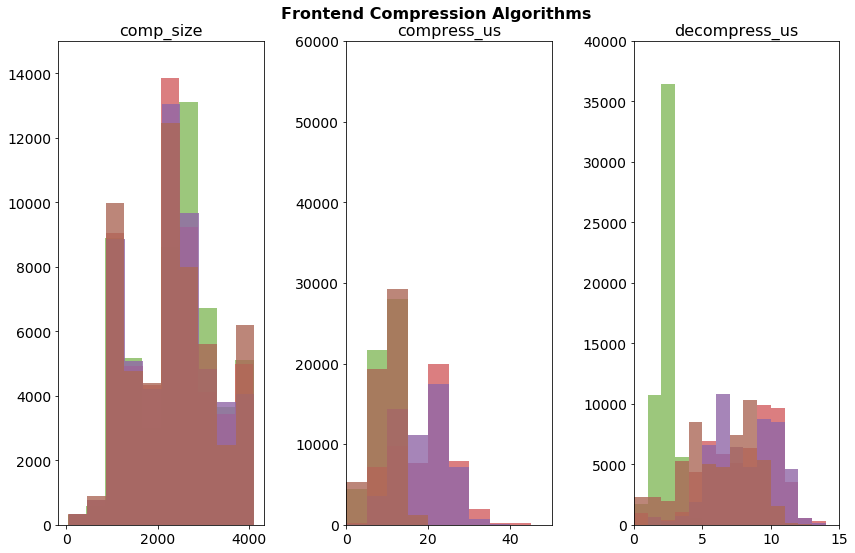

In [396]:
alg_group = 'frontend'
chart = 'hist'

compressed_dfs = [
    pd.read_csv(c.path, sep='|', header=None) for c in alg_groups[alg_group]
]

fig, axarr = plt.subplots(1, 3, figsize=(14, 8))
metrics = ['comp_size', 'compress_us', 'decompress_us']
i = 0
algs = []
file_names = None
comp_x = range(50)
decomp_x = range(15)
bin_ranges = [None, range(0, 50, 5), range(0, 15, 1)]

decomp_limit = 0
for c_df in compressed_dfs:
    c_df.columns = ['alg', 'comp_size', 'compress_us', 'decompress_us', 'file', 'block']
    c_df = c_df.groupby('alg')
    
    algs_in_df = dict()
    
    for alg in list(c_df.groups.keys()):
        if alg not in algs_in_df:
            algs.append(alg)
            algs_in_df[alg] =  i
            i += 1
            
        alg_df = c_df.get_group(alg)
        alg_df_len = len(alg_df)
        if alg_df_len > 1:
            compress_idx = [
                np.abs(alg_df.compress_us-alg_df.compress_us.mean())<= 3*alg_df.compress_us.std()]
            decompress_idx = [
                np.abs(alg_df.decompress_us-alg_df.decompress_us.mean())<= 3*alg_df.decompress_us.std()]
            comp_and_decomp = compress_idx and decompress_idx
        else:
            # quick and dirty way to handle the 1 block example
            comp_and_decomp = [[True]]
        comp_and_decomp_len = len([c for c in comp_and_decomp[0] if c])
        print('{}, {}, Removed {} of {} records'.format(alg_df.alg.iloc[0], alg_df.file.iloc[0],
                                                        alg_df_len - comp_and_decomp_len, alg_df_len))
        for m in range(len(metrics)):
            if chart == 'bar':
                axarr[m].bar(algs_in_df[alg], alg_df[comp_and_decomp[0]][metrics[m]].mean(),
                             color=bar_codes[comp_codes[alg]])
            elif chart == 'hist':
                axarr[m].hist(alg_df[comp_and_decomp[0]][metrics[m]],
                      color=bar_codes[comp_codes[alg]], alpha=0.8, bins=bin_ranges[m])
for alg in range(len(algs)):
    axarr[0].set_ylim(0, 15000)
    axarr[1].set_xlim(0, 50)
    axarr[1].set_ylim(0, 60000)
    axarr[2].set_xlim(0, 15)
    axarr[2].set_ylim(0, 40000)
    for m in range(len(metrics)):
        axarr[m].set_title('{}'.format(metrics[m]), fontsize=16)
        #if m == 0:
        #    axarr[alg, m].set_ylabel('bytes')
        #else:
        #    axarr[alg, m].set_ylabel('microseconds')
plt.subplots_adjust(top=0.92, bottom=0.08, hspace=0.5, wspace=0.4)
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("{} Compression Algorithms".format(alg_group.capitalize()), weight='bold', size=16)

#if chart == 'hist':
#    fig.legend(algs, loc='lower center', ncol=len(algs),  borderaxespad=0.2)

plt.show()

In [ ]:
def normalize(x):
    return (x - x.mean()) / x.std()
df = compressed_dfs[5]
df.columns = ['alg', 'comp_size', 'compress_us', 'decompress_us', 'file', 'block']
df = df.groupby(['alg', 'file'])
df.groups.keys()
#df.get_group(('bzip2', 'canterbury-large//E.coli'))

In [ ]:
df.groups.keys()